# Building a regression model for predicting house sale prices

In [564]:
import pickle
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [565]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

c:\Users\Gustavin\AmesML\data


In [566]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

In [567]:
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

In [568]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2751 entries, 0 to 2929
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   MS.SubClass     2751 non-null   category
 1   MS.Zoning       2751 non-null   category
 2   Lot.Frontage    2751 non-null   float64 
 3   Lot.Area        2751 non-null   float64 
 4   Lot.Shape       2751 non-null   category
 5   Land.Contour    2751 non-null   category
 6   Lot.Config      2751 non-null   category
 7   Land.Slope      2751 non-null   category
 8   Neighborhood    2751 non-null   category
 9   Bldg.Type       2751 non-null   category
 10  House.Style     2751 non-null   category
 11  Overall.Qual    2751 non-null   category
 12  Overall.Cond    2751 non-null   category
 13  Roof.Style      2751 non-null   category
 14  Mas.Vnr.Type    2751 non-null   category
 15  Mas.Vnr.Area    2751 non-null   float64 
 16  Exter.Qual      2751 non-null   category
 17  Exter.Cond      275

In [569]:
model_data = data.copy()

## Preparing the data for the model

Now that we have the data all cleaned, and all the missing values accounted for, lets focus on transforming the data for the model.

Lets remember what a model is. 

- A predictive model is a **set** of functions that receive data as input and produce a prediction, that is, an estimate of the target value as output.
- **Train** a model is to search the set of candidate functions for one that adequately represents the **training dataset**.
- The adequacy of a candidate function to the training data is usually determined by a **loss function** that measures how well the predictions of the function match the real values of the target within the training dataset. It is common to define a *loss function per data item* (e.g. absolute error, quadratic error, etc) and to construct the *loss function over the dataset* as the *average prediction loss*.

Many models are **parametric models**. In this case, each function of the set of functions that makes the model is constructed from a vector of **parameters** that define the function, forming a **parametric function**. For instance: the linear model constructs prediction values out of a linear combination of the input features, plus a constant. The weights of the linear combination plus the constant are the parameters of the model. The set of functions that can be represented by this model is given by all possible values of the vector of parameters that define the function.

Some models are called **non-parametric models**. These models usually do not have a parametric form (like the linear model). But the terminology is a bit misleading, though: usually these models *do* have parameters, and potentially an open-ended set of them! For instance, consider the "decision tree" model, which is one of the most prominent models of this category. The decision tree may not have a formula for the predicted value, but it does have parameters, many of them: each decision in the tree involves a choice of feature and a threshold level, and those choices must be stored as parameters of the model for use in future predictions.

Each model has specific requirements for the format of the input data. Most of the time, the minimum requirement is that:

- All columns are numeric;
- There are no missing values.

Some models have extra requirements. For example: the support-vector-machines model requires that the input features have comparable standard deviations - having features that have large discrepancies between features in terms of their order of magnitude (such as a feature in the fractions of unit range and another in the tens of thousands) will result in poor prediction quality.

And some models may not have any special requirement at all. We will study each of those in detail in this course.

Lets start our study with a simple model: the *multivariate linear regression* model. This is a model that presents the minimum requirements listed above. So we need to do a bit of processing on the original features:

- *Numerical features* stay as given;
- *Categorical features* have to be transformed into numerical features. In order to do so we need to **encode** these features, that is: to transform them into new features that convey the same information, but in a numerical form, and in a way that "makes sense" - we'll see it below.
- *Ordinal features* can be transformed into numerical features in the same way as the caegorical features, or could be assigned increasing numbers in conformity with the ordered nature of the categories of the feature.

## Encoding categorical variables

Lets identify all categorical variables - both nominal (that is, categoricals without category order) and ordinal.

In [570]:
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

In [571]:
ordinal_columns

['Lot.Shape',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Paved.Drive',
 'Fence']

In [572]:
categorical_columns

['MS.SubClass',
 'MS.Zoning',
 'Land.Contour',
 'Lot.Config',
 'Neighborhood',
 'Bldg.Type',
 'House.Style',
 'Roof.Style',
 'Mas.Vnr.Type',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Central.Air',
 'Garage.Type',
 'Garage.Finish',
 'Sale.Type',
 'Sale.Condition',
 'Condition',
 'Exterior']

### Encoding ordinal variables 

Ordinal variables can be transformed into integer numbers in a straightforward manner: the lowest category is assigned the value "zero", the next category is given the value "one", etc. The `Pandas` library has a function for this task: `factorize()`:

In [573]:
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

Lets confirm that the variables are no longer ordinal, but now are integers:

In [574]:
model_data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2751 entries, 0 to 2929
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Lot.Shape     2751 non-null   int64
 1   Land.Slope    2751 non-null   int64
 2   Overall.Qual  2751 non-null   int64
 3   Overall.Cond  2751 non-null   int64
 4   Exter.Qual    2751 non-null   int64
 5   Exter.Cond    2751 non-null   int64
 6   Heating.QC    2751 non-null   int64
 7   Electrical    2751 non-null   int64
 8   Kitchen.Qual  2751 non-null   int64
 9   Functional    2751 non-null   int64
 10  Paved.Drive   2751 non-null   int64
 11  Fence         2751 non-null   int64
dtypes: int64(12)
memory usage: 279.4 KB


Compare the original values with the encoded values:

In [575]:
data['Lot.Shape'].value_counts()

Lot.Shape
Reg     1738
IR1      929
IR2+      84
Name: count, dtype: int64

In [576]:
model_data['Lot.Shape'].value_counts()

Lot.Shape
0    1738
1     929
2      84
Name: count, dtype: int64

### Encoding nominal variables

With nominal variables there is no notion of order among categories. Therefore, it would be a conceptual mistake to encode them in the same manner as the ordinal variables. For instance, consider the `Exterior` variable:

In [577]:
model_data['Exterior'].value_counts()

Exterior
VinylSd    1010
HdBoard     426
MetalSd     410
Wd Sdng     374
Plywood     197
CemntBd     124
BrkFace      78
WdShing      51
Stucco       37
AsbShng      33
Other        11
Name: count, dtype: int64

We cannot assign an order here, lest we end up with equations like `HdBoard` + `Plywood` = `CemntBd`, which are nonsense. 

The strategy here to encode `Exterior` is to create several new numerical variables to represent the membership of a given data item to one of the `Exterior` categories. These are called **dummy variables**. Each of these new variables contain only the values "zero" or "one" (i.e. they are binary variables), where $1$ denotes that the data item belongs to the category represented by the variable. Evidently, for a given data item, only one dummy variable has a value of $1$, all remaining are $0$.

There are two types of dummy variable encoding:

- "One-hot" encoding: in this case we create one dummy variable per category. Let's look at the `Exterior` feature as an example. The `Pandas` function `get_dummies()` can do the encoding for us:

In [578]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
AsbShng,False,False,False,False,False
BrkFace,True,False,False,True,False
CemntBd,False,False,False,False,False
HdBoard,False,False,False,False,False
MetalSd,False,False,False,False,False
Plywood,False,False,False,False,False
Stucco,False,False,False,False,False
VinylSd,False,True,False,False,True
Wd Sdng,False,False,True,False,False
WdShing,False,False,False,False,False


Observe that for each value of `Exterior`, only the corresponding dummy is flagged.

One-hot encoding is a popular technique in Machine Learning. Statisticians, however, prefer a slightly different way of dummy encoding which is:

- Choose a category to *not encode* (this is called the *base category*)
- Generate dummies for the remaining categories. That is:
    - If the data item belongs to the base category, no dummy receives a value of $1$;
    - Otherwise, set the corresponding dummy to $1$.

The same `get_dummies()` function of `Pandas` can do this automatically with the `drop_first` argument:

In [579]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
BrkFace,True,False,False,True,False
CemntBd,False,False,False,False,False
HdBoard,False,False,False,False,False
MetalSd,False,False,False,False,False
Plywood,False,False,False,False,False
Stucco,False,False,False,False,False
VinylSd,False,True,False,False,True
Wd Sdng,False,False,True,False,False
WdShing,False,False,False,False,False
Other,False,False,False,False,False


Notice that we are now missing the dummy variable for the `AsbShng` category.

Why to encode things this way? If we don't drop one of the dummies, then it will always be the case that the sum of the values of the dummies is $1$ (since each data item must belong to one of the categories). The linear model, particularly very popular with the statisticians, implies the existence of a fictitious feature containing, for all data items, the value $1$. Hence we end up having a set of variables where a linear combination of them (in this case, the sum of the dummies) matches the value at another variable. This has numerical computing implications for the linear model, that we will discuss in class.

Since we want to use the linear model in this notebook, lets encode all categoricals with the `drop_first` alternative.

In [580]:
model_data = pd.get_dummies(model_data, drop_first=True)

Now our dataset has a lot more variables!

In [581]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2751 entries, 0 to 2929
Columns: 157 entries, Lot.Frontage to Exterior_Other
dtypes: bool(116), float64(29), int64(12)
memory usage: 1.2 MB


In [582]:
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2+", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NPkVill", "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_SawyerW", "Neighbor

In [583]:
data_columns = list(model_data.columns)

## Train-test splitting

The data will now be organized as follows:

- The features form a matrix $X$ of size $m \times n$, where $m$ is the number of data items, and $n$ is the number of features.
- The target forms a column-matrix $y$ of length $m$.

In [584]:
X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

In [585]:
X.values, y.values

(array([[141.0, 31770.0, 1, ..., False, False, False],
        [80.0, 11622.0, 0, ..., False, False, False],
        [81.0, 14267.0, 1, ..., True, False, False],
        ...,
        [62.0, 10441.0, 0, ..., False, False, False],
        [77.0, 10010.0, 0, ..., False, False, False],
        [74.0, 9627.0, 0, ..., False, False, False]], dtype=object),
 array([5.33243846, 5.0211893 , 5.23552845, ..., 5.12057393, 5.23044892,
        5.27415785]))

This is the typical set-up of a machine learning project. Now we want to train our model *and* verify that the model provides good predictions for *unseen* data items. Why the emphasis on "unseen"? Because there is no use for a model that only gives predictions for the items in the data used to train it - we want our models to *generalize*.

The way to assess the model's performance for unseen values is to split the dataset into two subsets: the **training** and **test** datasets.

We have been using a lot of `Pandas` to manipulate our data so far. From now on we will switch to another very popular library for machine learning in Python: `Scikit-Learn`.

The function `train_test_split()` will take as arguments the dataset to be split, the specification of the fraction of the dataset to be reserved for testing, and a random seed value - so that the split will always be the same whenever we run our notebook. This is a customary measure to ensure reproducibility of the notebook.

In [586]:
from sklearn.model_selection import train_test_split

In [587]:
RANDOM_SEED = 42  # Any number here, really.

In [588]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [589]:
X.shape, Xtrain.shape, Xtest.shape

((2751, 156), (2063, 156), (688, 156))

In [590]:
y.shape, ytrain.shape, ytest.shape

((2751,), (2063,), (688,))

In [591]:
def plot_importances(data_columns, feature_importances):
    l = zip(data_columns, feature_importances)
    sorted_list = sorted(l, key=lambda x: x[1], reverse=True)
    dict_importances = {col : importance for col, importance in sorted_list}
    dict_plot = dict(list(dict_importances.items())[0:10])
    x_plot = list(dict_plot.keys())
    y_plot = list(dict_plot.values())
    #ploting the graph 
    plt.figure(figsize=(5,3))
    plt.bar(x_plot, y_plot)
    plt.xticks(rotation=90)
    plt.show()

## Fitting a linear model

Lets start with fitting a linear model for regression. The linear model is one of the oldest and most used models for regression, due to its simplicity and strong statistical roots. A proper statistical approach to the understanding of the linear model consists of:

- Understanding the statistical premises of the linear model;
- Analyzing the features to verify that the preliminary conditions of this modeling strategy are satisfied;
- Fitting the model;
- Analyzing the residuals to confirm that the post-fit conditions are satisfied.

Lets discuss these topics in more detail:

### The statistical approach to the linear model

In machine learning we are more interested in the predictive capability of a model, rather than its inductive use to analyze the relation between features and target (or independent and dependent variables, in the statistical terminology). But even to a machine learning practitioner, understanding the statistical basis of the linear model may lead to better predictive performance. For instance:

- Having a symmetrical residual is usually associated with better mean-squared-error (MSE) than having a long-tailed assymmetric residual;
- Non-significant parameters (in a hypothesis-testing sense) may indicate superfluous variables in the model, which could be associated with reduced performance in the test dataset (i.e. poor generalization).

So what is the linear model in statistics? A statistical model is a way to describe probabilistically the relation between features and targets, usually in a parametric way.

Mathematically, we are searching for a *conditional probability* density model of the form $f(Y = y | \mathbf{x}, \theta)$ where $\mathbf{x}$ is the feature vector, $Y$ is the random variable associated with the target, and $\theta$ is the vector of parameters. In plain language, we would like to describe the probability distribution of the target variable when the value of the feature vector is known and the parameters of the model are given.

In the linear model, we postulate that the data $y$ is generated from the feature vector $\mathbf{x}$ plus a random Gaussian noise of fixed standard deviation, as shown in the equation below:

$$
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n + \varepsilon
$$

where $\varepsilon \sim N(0, \sigma)$

The addition of the noise term causes the $y$ value to become a random variable itself, thus making the probabilistic model mentioned above. For a given value of $\mathbf{x}$, the value of $y$ is obtained by adding the constant value $\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$ to a normal random variable $\varepsilon$. Remember that, for normal random variables, adding a constant keeps the variable normal, with a shifted mean-value parameter. Therefore:

$$
Y \sim N(\mu = (\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n), \sigma)
$$

Lets write

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n
$$

for simplicity, then the model above is rewritten as:

$$
Y \sim N(\mu = \hat{y}, \sigma)
$$

When we have a dataset $D = \{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \cdots, (\mathbf{x}_m, y_m)\}$ of several $(\mathbf{x}, y)$ pairs, what is their joint conditional probability density function $f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta)$?

We will make another supposition of the linear model: that the $(\mathbf{x}, y)$ examples were obtained independently, and that the value of one does not impact the probability of the other. Therefore:

$$
f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) = f(y_1| x_1, \theta) f(y_2| x_2, \theta) \cdots f(y_m| x_m, \theta) 
$$

Remember that the normal probability density function is as follows:

$$
Y \sim N(\mu, \sigma) \Rightarrow f(y) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y - \mu)^2}{\sigma^2} \right)
$$

Thus:

$$
Y \sim N(\mu = \hat{y}, \sigma) \Rightarrow f(y) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y - \hat{y})^2}{\sigma^2} \right)
$$

And the joint conditional probability density function of the entire dataset becomes:


$$
f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) = \prod_{i=1}^{m} \left(\frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right)
$$

Expanding the product we have:

$$
\begin{align*}
f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) & = & \prod_{i=1}^{m} \left(\frac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right) \\
& = & \prod_{i=1}^{m} \left(\frac{1}{\sigma \sqrt{2 \pi}} \right) \prod_{i=1}^{m} \left( \exp \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right) \\
& = & \left(\frac{1}{\sigma \sqrt{2 \pi}} \right)^{m} \exp \left(\sum_{i=1}^{m} \left(-\frac{1}{2}\frac{(y_i - \hat{y_i})^2}{\sigma^2} \right) \right) \\
& = & \left(\frac{1}{\sigma \sqrt{2 \pi}} \right)^{m} \exp \left(- \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right)
\end{align*}
$$

What are the "best" value for the parameters of the linear model? We can search for the parameters that maximize the joint conditional probability density function of the dataset. This function is called the *likelihood* of the parameters, and therefore our solution here is called a *"maximum likelihood estimate"* of the parameters.

So we are looking for a value $\theta^{\star}$ of $\theta$ to maximize $f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta)$, that is:

$$
\begin{align*}
\theta^{\star} & = & \argmax_{\theta} \left\{ f(y_1, y_2, \cdots, y_m | x_1, x_2, \cdots, x_n, \theta) \right\}\\
& = & \argmax_{\theta} \left\{ \left(\frac{1}{\sigma \sqrt{2 \pi}} \right)^{m} \exp \left(- \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right) \right\} \\
& = & \argmax_{\theta} \left\{ \exp \left(- \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right) \right\} \\
& = & \argmax_{\theta} \left\{ - \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
& = & \argmin_{\theta} \left\{ \frac{1}{2 \sigma} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
& = & \argmin_{\theta} \left\{ \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
& = & \argmin_{\theta} \left\{ \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y_i})^2 \right\} \\
\end{align*}
$$

Hey, look who we found! Our old friend MSE (mean-squared-error)!

So, in the end, here are the lessons:

- The statistical formulation of the linear model leads to the same error formulation of machine learning, which only cares for the prediction quality.
- The statistical linear model has several assumptions:
    - The samples are independent;
    - The target is *truly* generated from the linear predictive formula plus a normally-distributed error;
    - The error has zero mean and constant standard deviation (the *homoscedasticity* hypothesis);
    - There is no error in the feature measurement. That is, $\mathbf{x}_{i}$ are constants, not random variables. All the error is in the target;
- If the assumptions of the linear model are satisfied, you can analyze the parameters with greater sophistication (the machine learning formulation does not bring this finesse). For instance, you can run hypothesis tests on the values of the parameters to determine whether they refute the null hypothesis $\theta_i = 0$ with a given statistical significance level. Which, in plain language, means that you don't really trust that the associated feature impacts the target, or if it is just an accident.

In [592]:
from sklearn.linear_model import LinearRegression

In [593]:
model = LinearRegression()

model.fit(Xtrain, ytrain)

LinearRegression()

## Obtendo as pontuações do modelo linear e plotando os maiores coeficientes do modelo

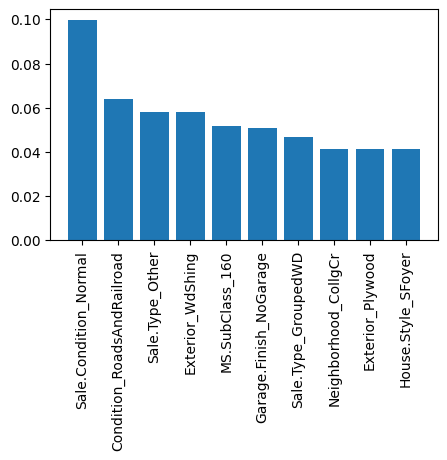

In [594]:
#importing cross validation function
from sklearn.model_selection import cross_val_score

linear_reg_rmse_scores = cross_val_score(model, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

linear_reg_rmse_scores = np.sqrt(-linear_reg_rmse_scores)

#getting the feature importances of linear regression model
feature_importances = model.coef_

plot_importances(data_columns, feature_importances)


## Obtendo as pontuações do modelo de árvore de decisão e plotando as features mais importantes

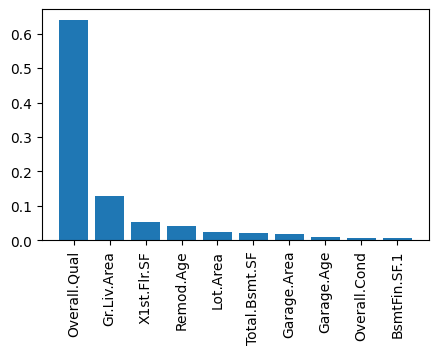

In [595]:
# Procurar os melhores parâmetros para a Random Forest.
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Vamos procurar os melhores parâmetros para o DecisionTreeRegressor.
grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    {'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)


grid_search.fit(Xtrain, ytrain)

# Vamos adotar o melhor regressor, ou seja, o RandomForestRegressor com os melhores hiperparâmetros.
tree = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
tree_scores = cross_val_score(tree, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

tree_rmse_scores = np.sqrt(-tree_scores)

feature_importances = grid_search.best_estimator_.feature_importances_

plot_importances(data_columns, feature_importances)

## Obtendo as pontuações do modelo de regressão Lasso e plotando os maiores coeficientes do modelo.

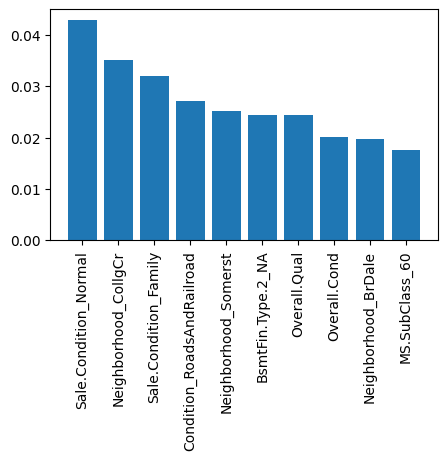

In [596]:
from sklearn.linear_model import Lasso

# Vamos procurar os melhores parâmetros para o Lasso.

grid_search = GridSearchCV(
    Lasso(max_iter=10000,random_state=RANDOM_SEED),
    {'alpha': [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

grid_search.fit(Xtrain, ytrain)

# Vamos adotar o melhor regressor, ou seja, o Lasso com os melhores hiperparâmetros.
lasso = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
lasso_scores = cross_val_score(lasso, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

lasso_rmse_scores = np.sqrt(-lasso_scores)

lasso_coeficientes = lasso.coef_

plot_importances(data_columns, lasso_coeficientes)

## Obtendo as pontuações do modelo de regressão Ridge e plotando os maiores coeficientes do modelo

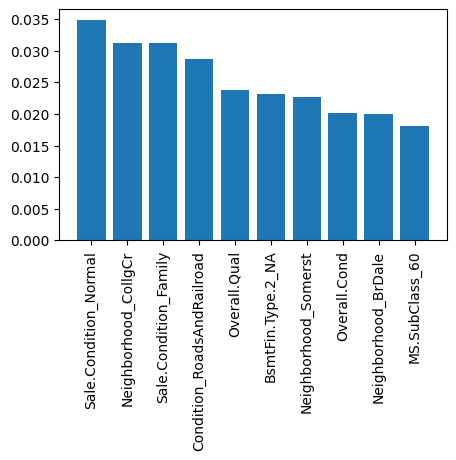

In [597]:
from sklearn.linear_model import Ridge

# Vamos procurar os melhores parâmetros para o Ridge

grid_search = GridSearchCV(
    Ridge(random_state=RANDOM_SEED),
    {'alpha': [0.01, 0.1, 1, 10, 100]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(Xtrain, ytrain)

# Vamos adotar o melhor regressor, ou seja, o RandomForestRegressor com os melhores hiperparâmetros.
ridge = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
ridge_scores = cross_val_score(ridge, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

ridge_rmse_scores = np.sqrt(-ridge_scores)

ridge_coeficientes = ridge.coef_

plot_importances(data_columns, ridge_coeficientes)

## Comparando modelos

#### Utilizamos o test t para avaliar se as amostras de scores obtidas pelos modelos têm médias estatisticamente significativas diferentes.

In [598]:
from scipy.stats import ttest_ind

def compare_scores(scores_1, scores_2):
    t_stat, p_value = ttest_ind(scores_1, scores_2, equal_var=False)
    print("Valor da estatística t: {:.2f}".format(t_stat))
    print("Valor-p: {}".format(p_value))
    return t_stat, p_value

#### No código abaixo, fica evidente que não temos como inferir um modelo melhor, tendo em vista as comparações entre o Lasso, Ridge e a Regressão Linear. Porém, podemos observar que os dados fornecem evidência convincente de o modelo de Árvore de decisão é inferior aos demais.

In [599]:
#tree vs lasso vs ridge
#importing mannwhitneyu
from scipy.stats import mannwhitneyu

def compare_models(name1, rmse_scores1, name2, rmse_scores2):
    t_stat, p_value = compare_scores(rmse_scores1, rmse_scores2)
    if p_value < 0.05:
        print(f'Erro médio de {name1} é significavelmente diferente de {name2}.')

dict_final = {'Linear Regression': linear_reg_rmse_scores, 'Decision Tree': tree_rmse_scores, 'Lasso': lasso_rmse_scores, 'Ridge': ridge_rmse_scores}
dict_perm = {'Lasso': ['Ridge'],'Linear Regression': ['Lasso','Ridge'], 'Decision Tree': ['Lasso','Ridge','Linear Regression']}

for key, value in dict_perm.items():
    for i in value:
        print(f"\nComparando {key} com {i}")
        compare_models(key, dict_final[key], i, dict_final[i])




Comparando Lasso com Ridge
Valor da estatística t: 0.01
Valor-p: 0.9940980373160676

Comparando Linear Regression com Lasso
Valor da estatística t: 0.17
Valor-p: 0.864383486902911

Comparando Linear Regression com Ridge
Valor da estatística t: 0.18
Valor-p: 0.8587309957877826

Comparando Decision Tree com Lasso
Valor da estatística t: 10.29
Valor-p: 7.522432536103319e-09
Erro médio de Decision Tree é significavelmente diferente de Lasso.

Comparando Decision Tree com Ridge
Valor da estatística t: 10.29
Valor-p: 7.485443430998512e-09
Erro médio de Decision Tree é significavelmente diferente de Ridge.

Comparando Decision Tree com Linear Regression
Valor da estatística t: 10.06
Valor-p: 1.0092876285641918e-08
Erro médio de Decision Tree é significavelmente diferente de Linear Regression.


#### Logo, podemos escolher qualquer um dos três modelos que possuem estatísticas semelhantes. Escolhemos pegar o com a menor média das pontuações de RMSE, ou seja, usaremos o Ridge.

In [600]:
print(f"Média das pontuações de RMSE na Regressão Linear: {linear_reg_rmse_scores.mean()}")
print(f"Média das pontuações de RMSE no Lasso: {lasso_rmse_scores.mean()}")
print(f"Média das pontuações de RMSE no Ridge: {ridge_rmse_scores.mean()}")

Média das pontuações de RMSE na Regressão Linear: 0.047426738395508525
Média das pontuações de RMSE no Lasso: 0.046821723461026254
Média das pontuações de RMSE no Ridge: 0.04679572679322852


### Aplicamos então o modelo Ridge para obter o RMSE. 

In [601]:
ridge.fit(Xtrain, ytrain)
ridge_pred = ridge.predict(Xtest)
RMSE = np.sqrt(mean_squared_error(ytest, ridge_pred))
RMSE


0.040359056734713274

In [602]:
error_percent = 100 * (10**RMSE - 1)
print(f'RIDGE: Average error is {error_percent:.2f}%')

RIDGE: Average error is 9.74%
